# **1 - Introduction**

---



The introduction chapter should be filled with an identity, an overview of the dataset used, and the objectives to be achieved.

Name : Andik Al Fauzi

Batch : FTDS-018-RMT

Dataset : [Fire Dataset](https://www.kaggle.com/datasets/phylake1337/fire-dataset)

Objective : Create a computer vision model with tensorflow to detect whether an image shows a fire condition or not according to the instructions. [Milestone 2 - Phase 2](https://github.com/H8-Assignments-Bay/p2---ftds-018-rmt---m2-andik-alfauzi)

# **2 - Import Libraries**

---



The first cell in the notebook should contain and only contain all the libraries used in the project.

In [ ]:
# Installing Kaggle
!pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing libraries
import os
import os.path
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import glob
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import cv2

# Importing model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# Importing Libraries
import pickle
sns.set_style('darkgrid')

# Warning Library
import warnings
warnings.filterwarnings('ignore')

# **3 - Data Loading**

---

This section contains the data preparation process before further data exploration. The Data Loading process can include giving new names to each column, checking the size of the dataset, etc.

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# persiapan Data Loading dan set kaggle
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle
!cp /content/drive/MyDrive/Haktiv8/kaggle.json ~/.kaggle

# Cek kaggle berhasil berhasil dijalankan
!ls ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory
kaggle.json


In [ ]:
# Get dataset from kaggle
!kaggle datasets download -d phylake1337/fire-dataset

 97% 376M/387M [00:03<00:00, 120MB/s]
100% 387M/387M [00:03<00:00, 115MB/s]


In [ ]:
# Extract dataset kaggle
!unzip -q /content/fire-dataset.zip

In [ ]:
# creating empty dataframe
df = pd.DataFrame(columns=['path','label'])

# making all fire images as 0
for dirname, _, filenames in os.walk('/content/fire_dataset/fire_images'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

# making all non-fire images as 1
for dirname, _, filenames in os.walk('/content/fire_dataset/non_fire_images'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))

# Reseting index    
df = df.sample(frac=1).reset_index(drop=True)

# Display
df.head(10)

,path,label
0,/content/fire_dataset/fire_images/fire.157.png,fire
1,/content/fire_dataset/fire_images/fire.331.png,fire
2,/content/fire_dataset/fire_images/fire.54.png,fire
3,/content/fire_dataset/fire_images/fire.296.png,fire
4,/content/fire_dataset/non_fire_images/non_fire...,non_fire
5,/content/fire_dataset/fire_images/fire.577.png,fire
6,/content/fire_dataset/fire_images/fire.688.png,fire
7,/content/fire_dataset/fire_images/fire.74.png,fire
8,/content/fire_dataset/fire_images/fire.469.png,fire
9,/content/fire_dataset/fire_images/fire.503.png,fire


In this part, I extracted the dataset from Kaggle and put it all into one dataframe.

# **4 - Exploratory Data Analysis (EDA)**

---

This section contains data exploration on the dataset above using queries, grouping, simple visualization, and so on.

<Axes: xlabel='label', ylabel='count'>

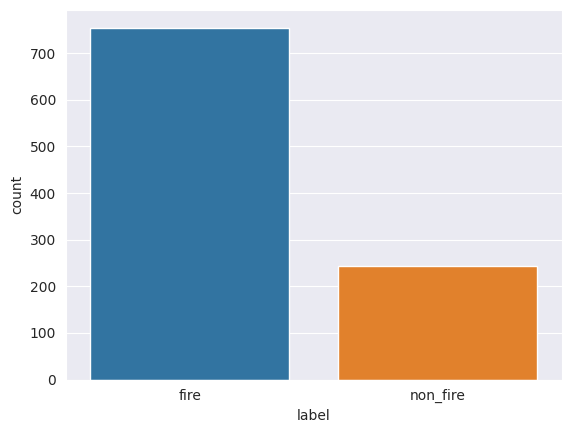

In [ ]:
# Histogram of label
sns.countplot(x=df['label'])

From the histogram above, the dataset looks imbalanced where the total images with fire dominate with more than 700 data compared to non-fire which amounts to 240 data.

In [ ]:
# Create a pie chart
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])
fig.add_trace(go.Pie(values=df['label'].value_counts().to_numpy(),
                     labels=df['label'].value_counts().index,marker=dict(colors=['rosybrown','lightgreen'])))

In accordance with the previous explanation, fire data dominates with 75.6% compared to non-fire with 24.4%.

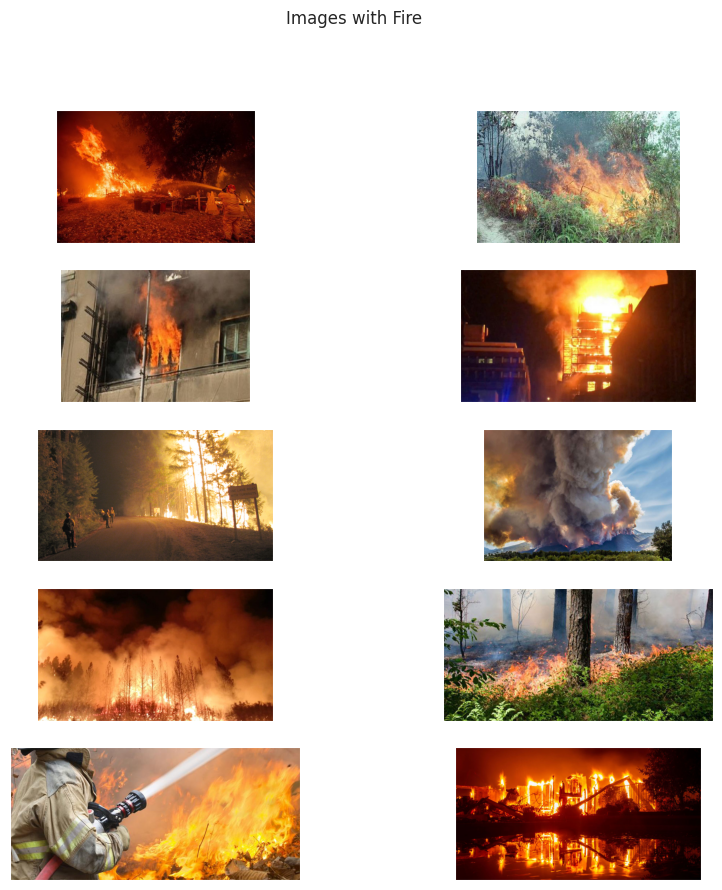

In [ ]:
# Get fire images
label = 'fire'
data = df[df['label'] == label]

# Get 10 images from dataframe
pics = 10
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

The following are fire images in the dataframe taken randomly as many as 10 pieces, where almost the average fire image has a color that tends to be dark and orange in color

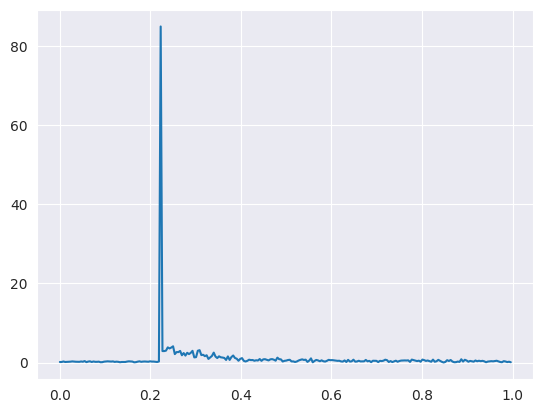

In [ ]:
# Load fire image
imageFire = cv2.imread('/content/fire_dataset/fire_images/fire.745.png')
gray = cv2.cvtColor(imageFire, cv2.COLOR_BGR2GRAY)

# Use hog features
hog_features, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

# Scaling hog features
scaler = StandardScaler().fit(hog_features.reshape(-1, 1))

# Transforming
hog_features = scaler.transform(hog_features.reshape(-1, 1)).reshape(-1)

# Find the color spectrum
hist, bins = np.histogram(hog_features, bins=256, range=(0, 1), density=True)

# Disply color spectrum
plt.plot(bins[:-1], hist)
plt.show()

As can be seen from the color spectrum curve above, the fire category image has:
1. The wavelength starts above 0.2
2. The highest color peak in the image is above 80
3. Pit in the fire image varies around 5
4. The color intensity in the fire image tends to be stagnant, which means that it is likely that the fire image has a color intensity that tends to darken

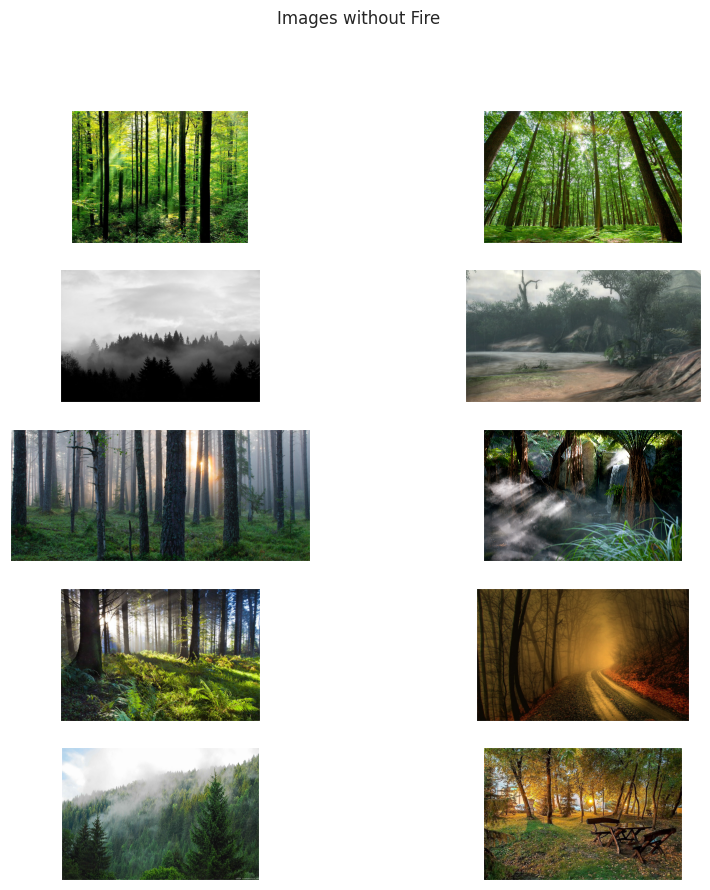

In [ ]:
# Get no-fire images
label = 'non_fire' 
data = df[df['label'] == label]

# Get 10 images
pics = 10
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images without Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

The following are non-fire images in the dataframe taken randomly as many as 10 pieces, where almost the average non-fire image has a color that tends to be bright and green

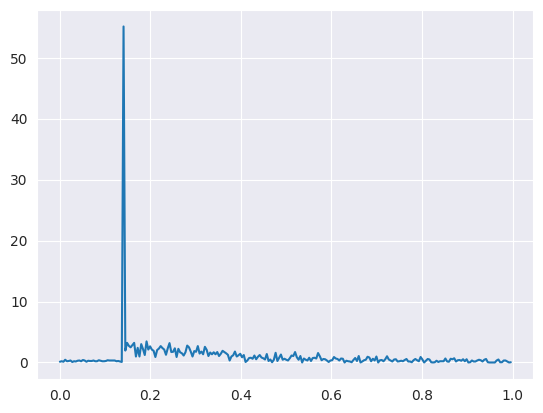

In [ ]:
# Load non-fire image
imageNoFire = cv2.imread('/content/fire_dataset/non_fire_images/non_fire.139.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use hog features
hog_features, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

# Scaling hog features
scaler = StandardScaler().fit(hog_features.reshape(-1, 1))

# Transforming
hog_features = scaler.transform(hog_features.reshape(-1, 1)).reshape(-1)

# Find the color spectrum
hist, bins = np.histogram(hog_features, bins=256, range=(0, 1), density=True)

# Disply color spectrum
plt.plot(bins[:-1], hist)
plt.show()

As can be seen from the color spectrum curve above, the non-fire category image has:
1. The wavelength starts from 0.2
2. The highest color peak in the image is below 60
3. Pit on non-fire image varies around 4
4. The color intensity in the non-fire image varies greatly, it is likely that the non-fire image has a fairly bright color intensity

In [ ]:
# Get the shape of each images
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/fire_dataset/fire_images/fire.157.png,fire,720,1280
1,/content/fire_dataset/fire_images/fire.331.png,fire,558,992
2,/content/fire_dataset/fire_images/fire.54.png,fire,242,323
3,/content/fire_dataset/fire_images/fire.296.png,fire,450,670
4,/content/fire_dataset/non_fire_images/non_fire...,non_fire,240,808


It can be seen that the shape of each image differs from one another

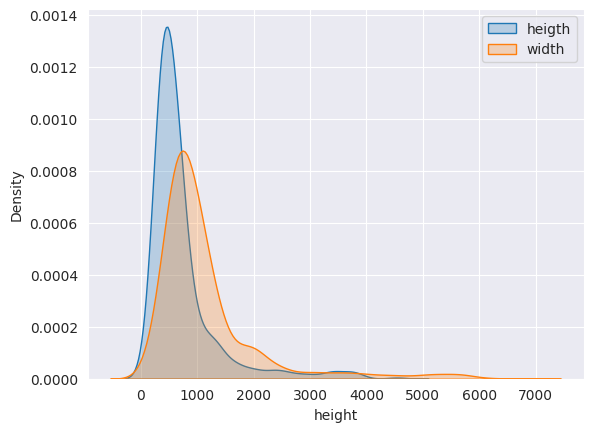

In [ ]:
# Shape of images distribution
sns.kdeplot(data=df["height"], shade=True, label='heigth')
sns.kdeplot(data=df["width"], shade=True, label='width')
plt.legend()
plt.show()

Here is the distribution of shape images. Many of the images have a width around 900 and a height around 750.



In [ ]:
# Check dupliated data
print('Duplicated Data : ', df.duplicated().sum())

Duplicated Data :  0


No duplicated data

# **5. Data Preprocessing**

---

This section contains the process of preparing the data for the model training process, such as dividing the data into train-tests, data transformation (normalization, encoding, etc.), and other necessary processes.

## 5.1 Splitting Data

In [ ]:
# Splitting dataset
# Train-val-set and test-set
trainValSet, testSet = train_test_split(df, test_size=0.15, random_state=19)

# Train-set and val-set
trainSet, valSet = train_test_split(trainValSet, test_size=0.2, random_state=19)

# Check shape of data
print('Train-set Shape : ', trainSet.shape)
print('Validation-set Shape : ', valSet.shape)
print('Test-set Shape : ', testSet.shape)

Train-set Shape :  (679, 4)
Validation-set Shape :  (170, 4)
Test-set Shape :  (150, 4)


The following is the division of the dataset where

1. Train data 65% with a total of 679 data
2. 20% validation data with a total of 170 data
3. 15% test data with a total of 150 data

## 5.2 Image Generator

In [ ]:
# Declare image data generator
trainGen = ImageDataGenerator(
    rotation_range = 20,
    rescale = 1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 0.2,
    brightness_range = (0.5, 1.5),
    validation_split = 0.2 
)

testGen = ImageDataGenerator(
    rescale = 1./255
)

In this section I declare the image data generator with:

1. Rescaling image pixels from 0 - 1
2. Rotating the image by 20 degrees
3. width_shift_range serves to shift the image to the right and left by 10% from the original position
4. height_shift_range serves to shift the image up and down by 10% of the original position
5. shear_range serves for image rotation transformation of a maximum of 20% from the initial position
6. brightness_range serves to adjust the brightness of the image from 50% to 150% of the initial brightness
7. validation_split is responsible for creating 80% train data and 20% validation data.

##5.3 Tensorflow Pipeline

In [ ]:
# Declare size 
img_height = 256
img_width = 256
batch_size = 32

I set the image height and width to 256x256 to get uniformity and set the batch_size as 32 batches.



In [ ]:
# Create a pipeline for data
train = trainGen.flow_from_dataframe(dataframe = trainSet,
                                     x_col = 'path',
                                     y_col = 'label',
                                     target_size = (img_height,img_width),
                                     class_mode = 'binary',
                                     batch_size = batch_size,
                                     image_size=(img_height,img_width),
                                     shuffle = True,
                                     subset='training')

val = trainGen.flow_from_dataframe(dataframe = valSet,
                                   x_col = 'path',
                                   y_col = 'label',
                                   target_size = (img_height,img_width),
                                   class_mode = 'binary',
                                   batch_size = batch_size,
                                   image_size=(img_height,img_width),
                                   shuffle = True,
                                   subset='validation')

test = testGen.flow_from_dataframe(dataframe = testSet,
                                     x_col = 'path',
                                     y_col = 'label',
                                     target_size = (img_height,img_width),
                                     class_mode = 'binary',
                                     batch_size = batch_size,
                                     image_size=(img_height,img_width),
                                     shuffle = True)

Found 544 validated image filenames belonging to 2 classes.
Found 34 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In this section, I use the flow_from_dataframe library with :

1. Setting the dataframe directory and specifying the path and label of the data.
2. target_size, according to the declaration above I set the target_size to 256x256. There is no particular reason but so that the resulting data can be uniform in size.
3. class_mode = binary because the data I have is only fire and non-fire
image_size, to determine the size of the image that will be converted by the generator to 256x256
4. batch_size is 32. There is no special reason, I just take a random number.

In [ ]:
class_indices = {}
for key in train.class_indices.keys():
    class_indices[train.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


From the data I have, it can be said that the mapping data is 0 for fire category images and data is 1 for non-fire category images.

# **6 - Model Baseline**

---



## 6.1 Model Definition

---

This section contains cells to define the model. Explain the reason for using an algorithm/model, the hyperparameters used, the type of metrics used, and anything else related to the model.

In [ ]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

I use clear_session to clean up memory so that the model doesn't get confused if there are different models and help avoid problems when building models later.

In [ ]:
# Model definition
model = Sequential()

# Convolutional - Pool 1
model.add(Conv2D(filters = 32, kernel_size = 3, activation='relu', 
                 input_shape=(img_height, img_width, 3)))

model.add(MaxPool2D())

# Convolutional - Pool 2
model.add(Conv2D(filters = 64, kernel_size = 3, activation='relu'))

model.add(MaxPool2D())

# Convolutional - Pool 3
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))

model.add(MaxPool2D())

# Flatten layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

The model I used to build the architecture was a Sequential Model with:

1. Convolutional first layer with 32 filters, kernel_size=3, activation_function relu and input shape 256x256 
2. MaxPooling2D with default parameters to avoid overfitting the data 
3. Convolutional second layer with 64 filters, kernel_size=3 and activation_function relu 
4. Then I reduce the layer again with MaxPooling2D with default parameters 
5. Convolutional third layer with 128 filters, kernel_size=3 and activation_function relu 
6. Then I reduce the layer again with MaxPooling2D with default parameters 
7. I change the dimensions to 1D by using Flatten 
8. I use 2 hidden layers with 64 and 32 neurons with activation_function relu 
9. Because the resulting target is binary_class then I only use 1 neuron with activation_function sigmoid 
10. I compile all the above parameters using optimizer='adam', loss function binary_crossentropy because the resulting target is binary_class and the metrics used are accuracy so that the model precisely provides the desired results.

## 6.2 Model Training

---



The cells in this section only contain code to train the model and the resulting output. Perform several training processes with different hyperparameters to see the results obtained. Analyze and narrate these results in the Model Evaluation section.

In [ ]:
# Set Callback
callback = [EarlyStopping(monitor = 'val_loss',
                          patience = 3, 
                          restore_best_weights=True),
            
            ModelCheckpoint('base_model.h5',
                            monitor = 'val_loss',
                            save_best_only = True),
            
            ReduceLROnPlateau(monitor ='val_loss',
                              factor = 0.1,
                              patience = 3)
            ]

To be able to control how the model is trained, I use callbacks with parameters:

1. Early Stopping with monitor = val_loss, patience = 3 where if the model does not show performance then the training will be stopped at the third epochs. restore_best_weights is used to decide if the model weights should be restored to the current best weights, which happens during training the performance does not improve in some epochs.
2. ModelCheckpoint to save the base model with the name base_model.h5, with training monitors val_loss and save_best_only to control whether or not the best model weights should be saved into the file.
3. ReduceLROnPlateau is used to reduce the learning rate if it does not show improvement after several epochs with parameters monitor = val_loss, learning reduction factor 0.1 and patience 3 if there is no performance then the training will be stopped at the third epoch.

In [ ]:
# fit the model
%%time
historyBase = model.fit(train, validation_data = val,
                        epochs = 10, verbose = 1,
                        callbacks = callback)

# Save into dataframe
historyBaseDF = pd.DataFrame(historyBase.history)
historyBaseDF

Epoch 1/10
17/17 [==============================] - 30s 2s/step - loss: 0.5303 - accuracy: 0.7040 - val_loss: 0.3975 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - 35s 2s/step - loss: 0.2662 - accuracy: 0.9136 - val_loss: 0.2036 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - 27s 2s/step - loss: 0.1903 - accuracy: 0.9265 - val_loss: 0.2290 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 4/10
17/17 [==============================] - 31s 2s/step - loss: 0.1543 - accuracy: 0.9412 - val_loss: 0.1654 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 5/10
17/17 [==============================] - 29s 2s/step - loss: 0.1699 - accuracy: 0.9393 - val_loss: 0.1470 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 6/10
17/17 [==============================] - 32s 2s/step - loss: 0.1236 - accuracy: 0.9614 - val_loss: 0.0808 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 7/10
17/17 [==============================] - 28s 2s/step - loss: 0.0863 - a

,loss,accuracy,val_loss,val_accuracy,lr
0,0.530311,0.704044,0.397457,0.852941,0.001
1,0.266239,0.913603,0.203621,0.911765,0.001
2,0.190261,0.926471,0.229037,0.911765,0.001
3,0.154293,0.941176,0.165365,0.911765,0.001
4,0.169887,0.939338,0.147015,0.911765,0.001
5,0.123601,0.961397,0.080821,0.941176,0.001
6,0.086310,0.977941,0.120531,0.911765,0.001
7,0.100826,0.952206,0.091591,0.970588,0.001
8,0.070549,0.983456,0.077507,0.970588,0.001
9,0.063000,0.977941,0.107848,0.941176,0.001


In this chart we train the data with the Sequential base model and store the training history in the dataframe.

## 6.3 Model Evaluation

---

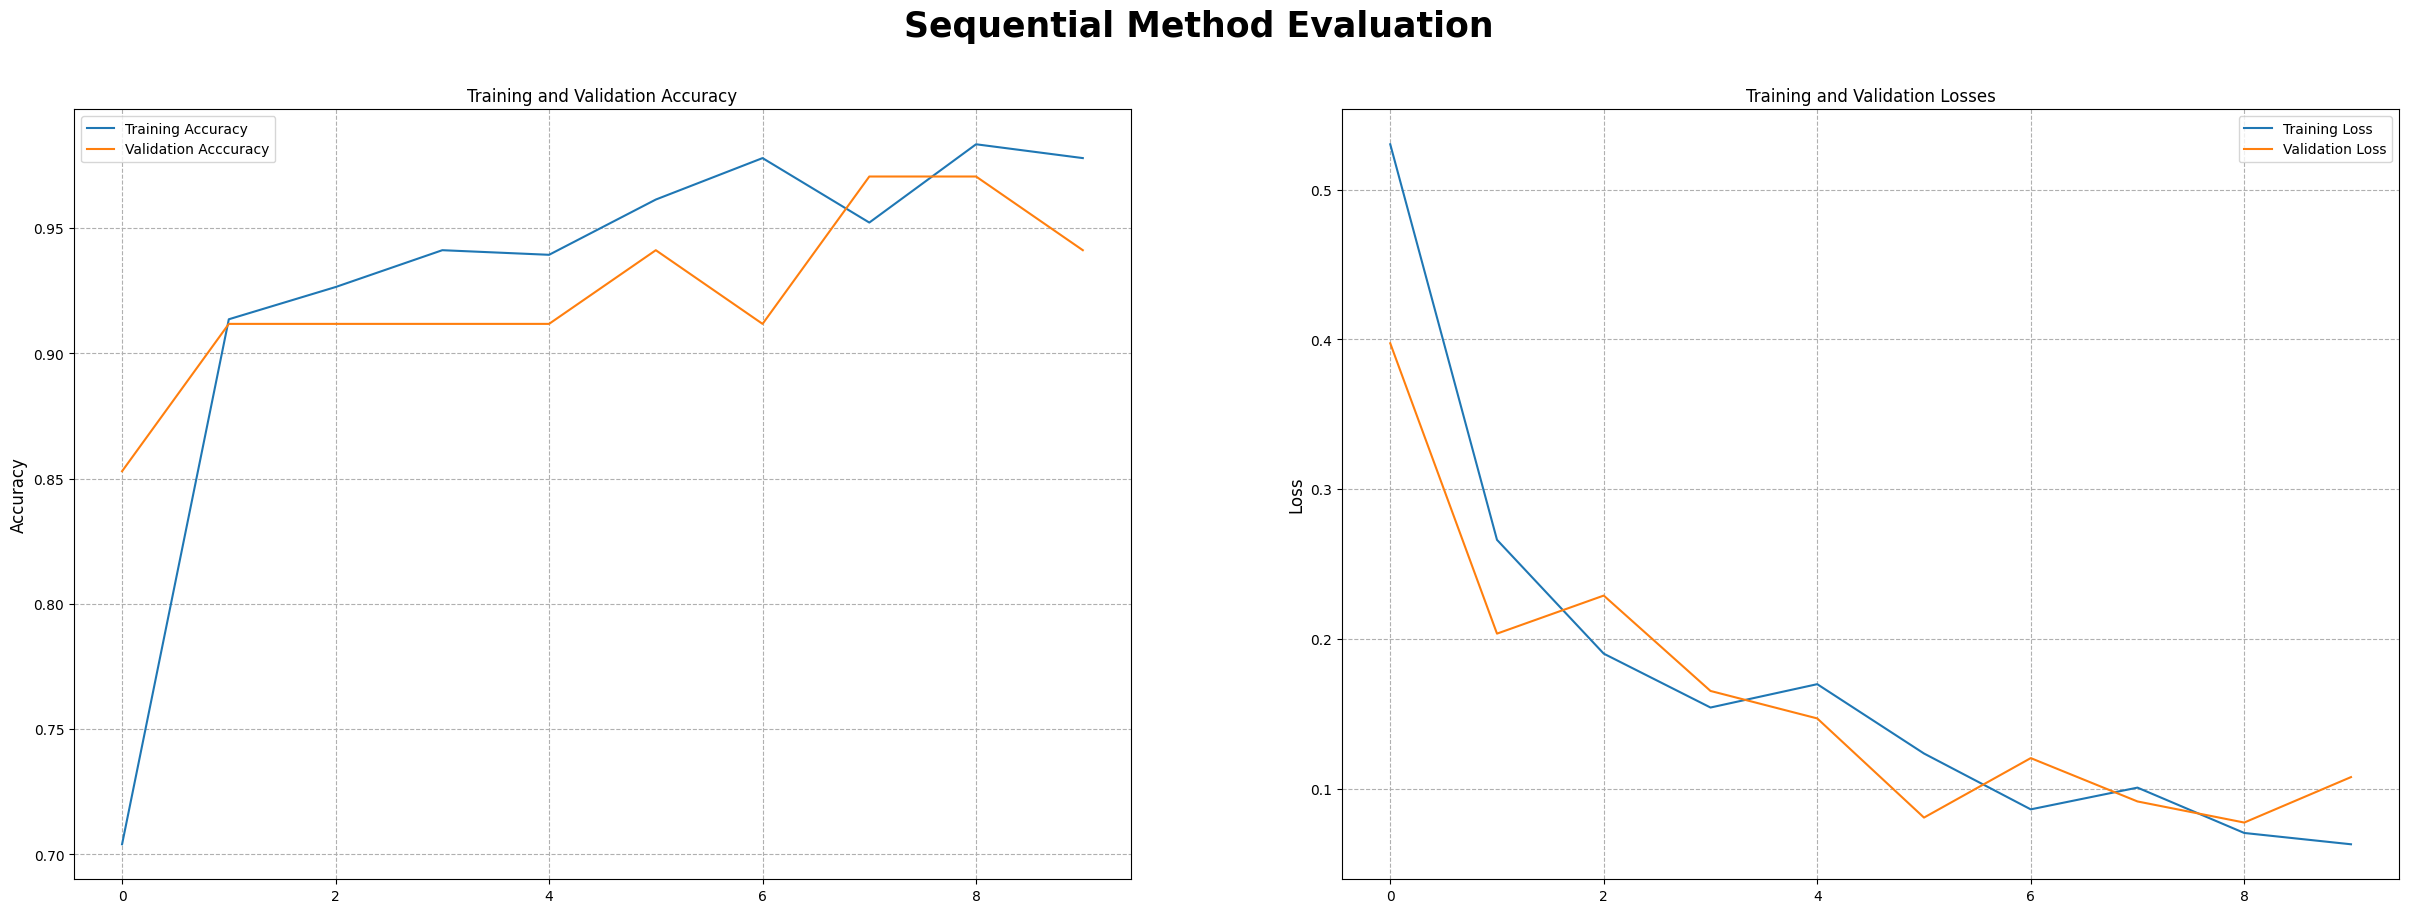

In [ ]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(historyBaseDF.accuracy,label="Training Accuracy")
plt.plot(historyBaseDF.val_accuracy, label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(historyBaseDF.loss, label="Training Loss")
plt.plot(historyBaseDF.val_loss, label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

1. It can be seen in the training and validation accuracy graphs, the model reaches around 95%. This shows that the model can work quite well.
2. It can be seen in the training and validation loss graphs, the model shows an error rate below 2%. Although from the two graphs above the model is a little overfit.
3. It can be said that this sequential base model is a good fit.

In [ ]:
# Apply model to predict
%%time
y_predTrainBase = tf.round(model.predict(train))
y_predTestBase = tf.round(model.predict(val))
y_trainBase = train.classes
y_testBase = val.classes

2/2 [==============================] - 1s 86ms/step
CPU times: user 28.8 s, sys: 927 ms, total: 29.8 s
Wall time: 29.6 s


In [ ]:
# Check model result
resultBase = model.evaluate(test, verbose=0)
print(f'Test Loss     : {resultBase[0]:.4f}')
print(f'Test Accuracy : {resultBase[1]:.4f}')

Test Loss     : 0.1873
Test Accuracy : 0.9333


The base model has a 93% accuracy and 1.8% loss rate.

# **7 - Model Improvement**

---



##7.1 Model Definition

In [ ]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

I use clear_session to clean up memory so that the model doesn't get confused if there are different models and help avoid problems when building models later.

In [ ]:
# Improve model with transfer learning and Xception
pretrained_model = tf.keras.applications.Xception(include_top=False, 
                                                  input_shape=(img_height,img_width, 3),
                                                  pooling='avg')
pretrained_model.trainable = False

- The Xception architecture aims to improve efficiency and accuracy in image recognition tasks.
- I set include_top to False so that later I can redefine the fully connected layer.
- input_shape is 256x256 according to the initial declaration.
- The pooling I use is average, which takes the average value of each feature in each block so that a single feature vector is produced that represents all the features in the block.
- pretrained_model.trainable = False means that I use the weight of the model that has been trained so that it does not need to be retrained.

In [ ]:
model2= Sequential()
model2.add(pretrained_model)

#fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu')),
model2.add(Dense(256, activation='relu')),
model2.add(Dense(units=1,activation='sigmoid'))

- Improving sequential model with transfer learning Xception
- Flatten is used to convert the dimensions to 1D
- Hidden layer with 128 and 256 neurons with activation_function relu
- Output target with sigmoid because the target generated is binary_class

In [ ]:
# Compile model
model2.compile(optimizer = 'RMSProp', loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Summary model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,157,033
Trainable params: 295,553
Non-trainable params: 20,861,480
_________________________________________________________________


I compiled all the parameters above using optimizer= `RMSProp` so that I can see the performance if I use a different optimizer, loss function binary_crossentropy because the resulting target is binary_class and the metrics used is accuracy so that the model exactly gives the desired result.

##7.2 Model Training

In [ ]:
# Set Callback improvement
impCallback = [EarlyStopping(monitor = 'val_loss',
                          patience = 5, 
                          restore_best_weights=True),
            
            ModelCheckpoint('imp_model.h5',
                            monitor = 'val_loss',
                            save_best_only = True),
            
            ReduceLROnPlateau(monitor ='val_loss',
                              factor = 0.1,
                              patience = 5)
            ]

To be able to control how the model is trained, I use improvement callbacks with parameters:

1. Early Stopping with monitor = val_loss, patience = 5 where if the model does not show performance then training will be stopped at the fifth epochs. restore_best_weights is used to decide if the model weights should be restored to the current best weights that occurred during training if performance does not improve within a few epochs.
2. ModelCheckpoint to save the base model with the name imp_model.h5, with training monitors val_loss and save_best_only to control whether the best model weights are saved into the file or not.
3. ReduceLROnPlateau is used to reduce the learning rate if it does not show improvement after several epochs with parameters monitor = val_loss, learning reduction factor 0.1 and patience 5 if there is no performance then training will be stopped at the fifth epoch.

In [ ]:
# fit the model improvement
%%time
historyImp = model2.fit(train, validation_data = val,
                        epochs = 10, verbose = 1,
                        callbacks = impCallback)

# Save into dataframe
historyImpDF = pd.DataFrame(historyImp.history)
historyImpDF

Epoch 1/10
17/17 [==============================] - 33s 2s/step - loss: 0.2897 - accuracy: 0.8493 - val_loss: 0.2459 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - 28s 2s/step - loss: 0.1275 - accuracy: 0.9522 - val_loss: 0.2410 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - 27s 2s/step - loss: 0.0952 - accuracy: 0.9743 - val_loss: 0.2428 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 4/10
17/17 [==============================] - 27s 2s/step - loss: 0.0938 - accuracy: 0.9761 - val_loss: 0.3097 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 5/10
17/17 [==============================] - 28s 2s/step - loss: 0.0933 - accuracy: 0.9669 - val_loss: 0.2030 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 6/10
17/17 [==============================] - 27s 2s/step - loss: 0.0516 - accuracy: 0.9816 - val_loss: 0.2539 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 7/10
17/17 [==============================] - 27s 2s/step - loss: 0.0652 - a

,loss,accuracy,val_loss,val_accuracy,lr
0,0.289733,0.849265,0.245867,0.882353,0.001
1,0.127509,0.952206,0.240994,0.941176,0.001
2,0.095202,0.974265,0.242818,0.941176,0.001
3,0.093781,0.976103,0.309733,0.911765,0.001
4,0.093274,0.966912,0.202954,0.941176,0.001
5,0.051649,0.981618,0.253923,0.941176,0.001
6,0.065219,0.981618,0.238181,0.941176,0.001
7,0.060301,0.977941,0.194949,0.941176,0.001
8,0.038295,0.987132,1.008274,0.794118,0.001
9,0.062523,0.981618,0.189398,0.911765,0.001


In this chart we train the data with the Sequential improvement model and store the training history in the dataframe.

##7.3 Model Evaluation

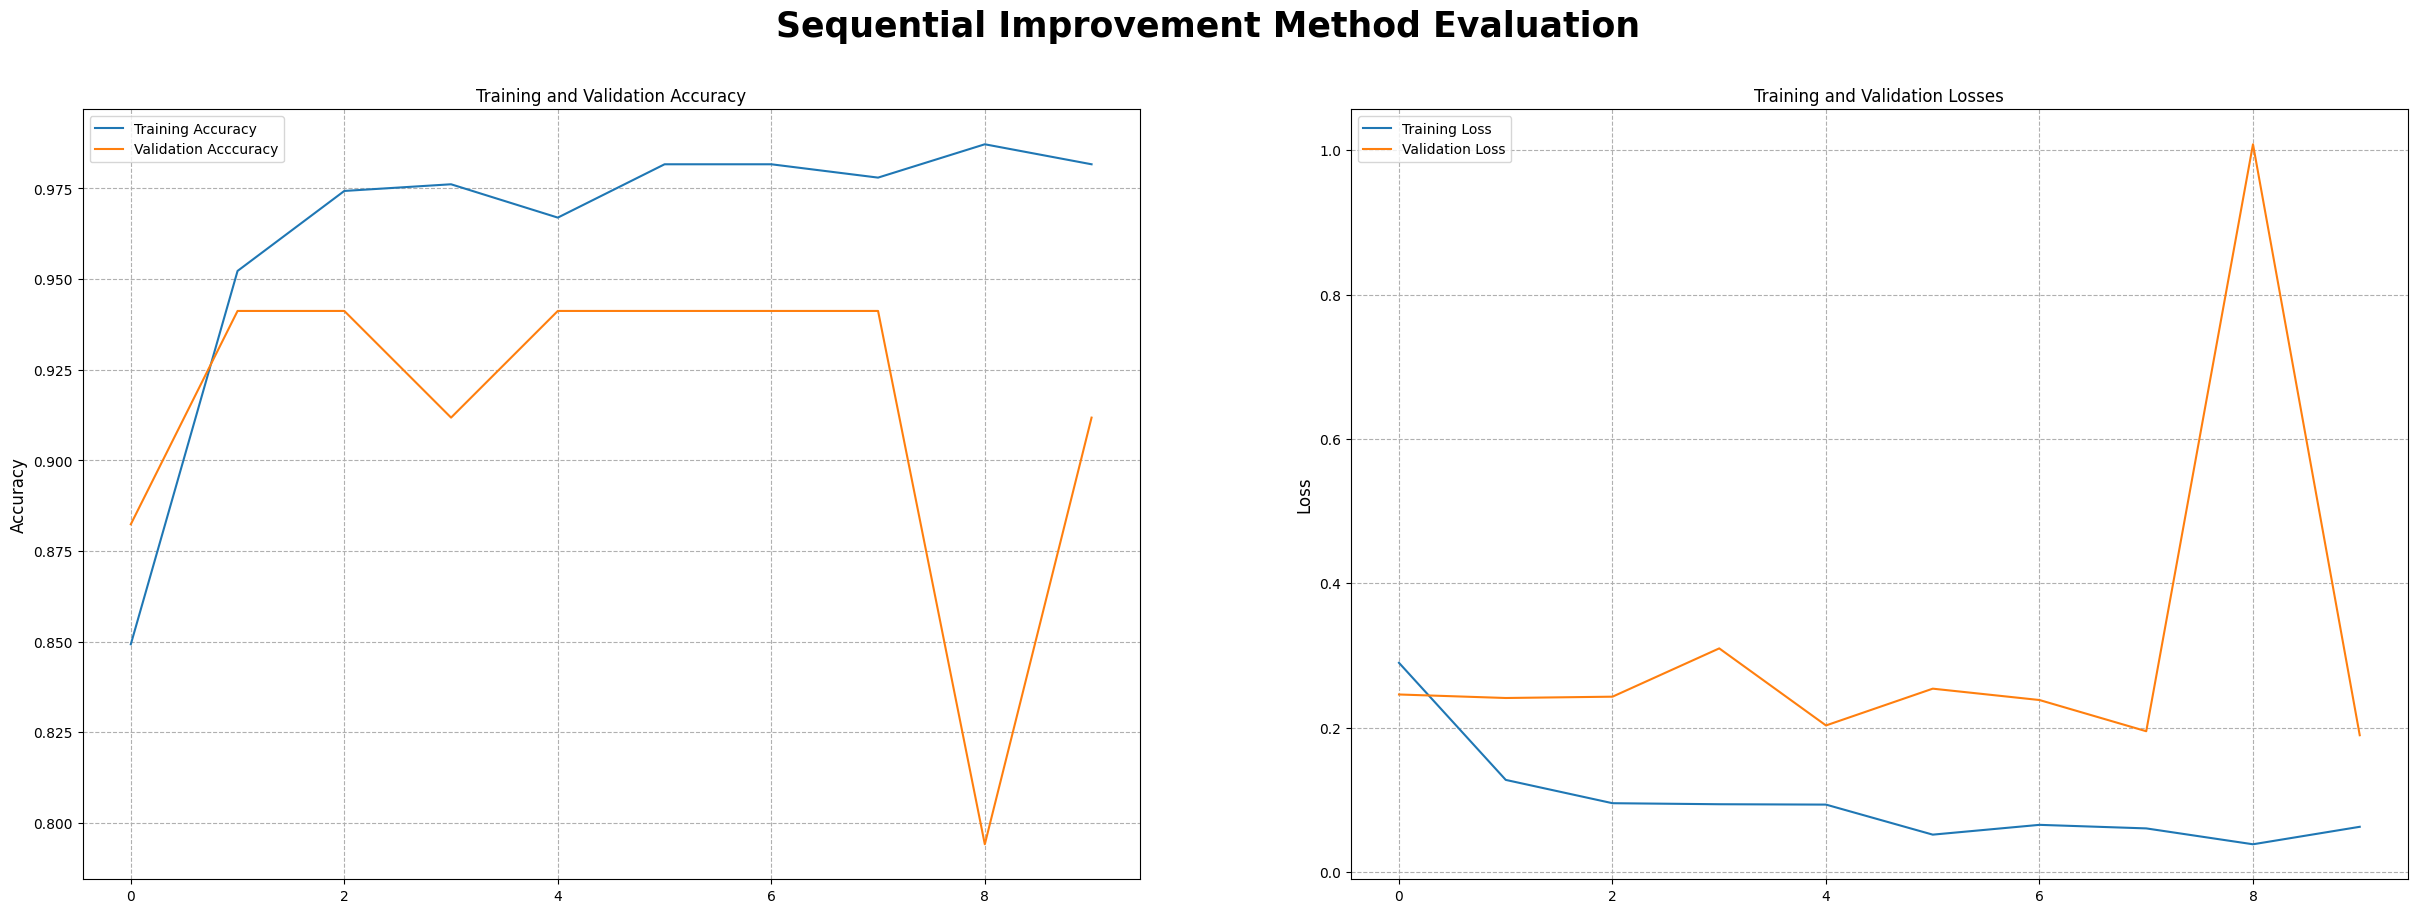

In [ ]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Improvement Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(historyImpDF.accuracy,label="Training Accuracy")
plt.plot(historyImpDF.val_accuracy, label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(historyImpDF.loss, label="Training Loss")
plt.plot(historyImpDF.val_loss, label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

1. It can be seen in the training and validation accuracy graphs, the model reaches more than 96% in training accuracy while in validation accuracy the score is around 91%. This shows that the model can improve and work quite well even though the model is slightly overfit.
2. It can be seen in the training and validation loss graphs, the model shows an average error rate below 2%. Although from the two graphs above the model is slightly overfit
3. It can be said that this sequential improvement model is a good fit.

In [ ]:
# Apply model to predict
%%time
y_predTrainImp = tf.round(model2.predict(train))
y_predTestImp = tf.round(model2.predict(val))
y_trainImp = train.classes
y_testImp = val.classes

2/2 [==============================] - 1s 149ms/step
CPU times: user 32.6 s, sys: 709 ms, total: 33.3 s
Wall time: 31.3 s


In [ ]:
resultImp = model2.evaluate(test, verbose=0)
print(f'Test Loss     : {resultImp[0]:.4f}')
print(f'Test Accuracy : {resultImp[1]:.4f}')

Test Loss     : 0.1820
Test Accuracy : 0.9600


1. The test loss value in this improvised model is slightly increased by 0.05% of the basic model
2. The test accuracy value in this improvised model has increased by 3% compared to the basic sequential model. It can be said that this improvised model performs better than the basic model.

# **8 - Model Evaluation**

---



## 8.1 Evaluate model with Confusion Matrix

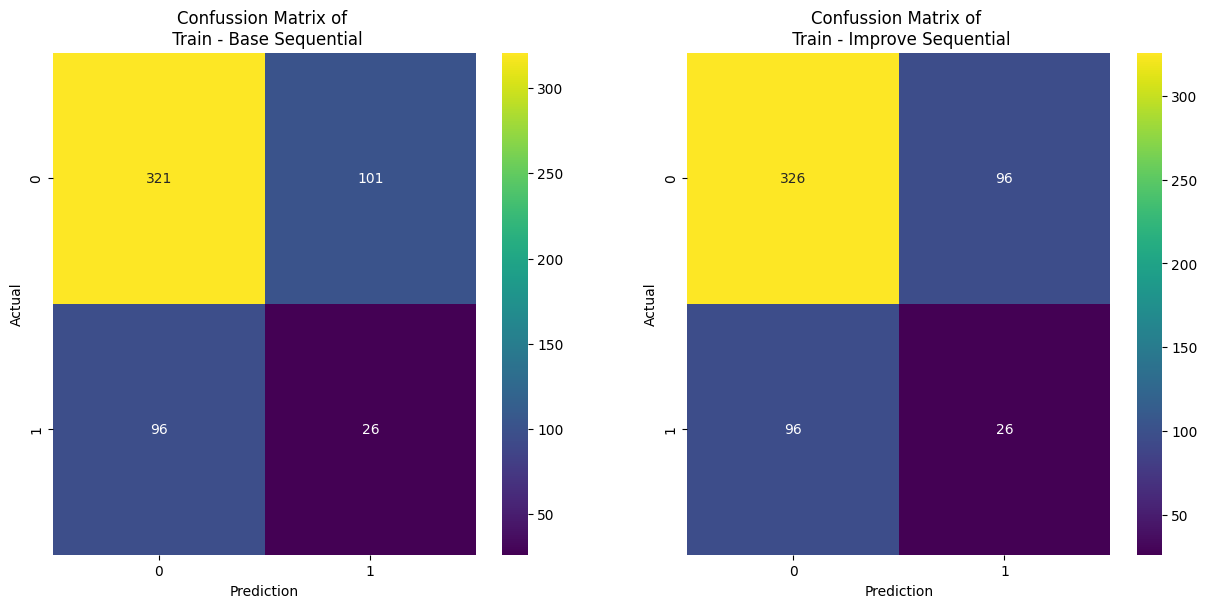

CPU times: user 399 ms, sys: 109 ms, total: 508 ms
Wall time: 394 ms


In [ ]:
# Evaluate model with confussion matrix
%%time
modelCM = [confusion_matrix(y_trainBase, y_predTrainBase),
           confusion_matrix(y_trainImp, y_predTrainImp)]

modelAlias = ['Train - Base Sequential', 'Train - Improve Sequential']

# Confussion matrix
plt.figure(figsize = (15, 30))
for i in range(len(modelCM)):
  plt.subplot(4, 2, i+1)
  fig = sns.heatmap(modelCM[i], annot=True, fmt = 'd', cmap = 'viridis')
  plt.title(f'Confussion Matrix of \n {modelAlias[i]}')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
plt.show()

Note : 
- class 0 : fire
- class 1 : non-fire

From the confusion matrix above, it can be concluded:

1. False Negative is the model error in predicting whether the image is non-fire while the actual is fire.
2. From the basic sequential model, the false negative is 18.6% of the total data.
3. From the improved sequential model, the false negative is 17.6% of the total data
4. The improved sequential model shows an improvement in false negatives of about 1%. This is good enough because I need fewer false negative errors.

## 8.2 Model Conclusion

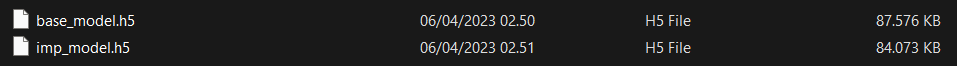

The following is a comparison of the file size of the basic model and the sequential improvement model. As we can see, the size of improvement model sequential is have a smaller size compared to the basic sequential model

In [ ]:
# Model conclustion
model2.trainable = False
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,157,033
Trainable params: 0
Non-trainable params: 21,157,033
_________________________________________________________________


Based on the confusion matrix and the size of the model that will be maintained later, I hereby choose to use the **Sequential Improvement Model** to be used in the inference model.

# **9 - Model Saving**

---



In [ ]:
# Saving the model
# Model CNN Saving
model2.save('imp_model.h5')

I saved a model with the name imp_model.h5 that will be used later.